In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Statistical_Genetics/
!pwd

Mounted at /content/drive
/content/drive/MyDrive/Statistical_Genetics
/content/drive/MyDrive/Statistical_Genetics


In [2]:
from CB_02704 import *
import pandas as pd
import numpy as np
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import scipy
import itertools

# Pre-Processing

In [ ]:
sumstats_data = pd.read_csv("StatGen_Project_Data/PASS_Intelligence_SavageJansen2018.sumstats", sep='\t')
print(sumstats_data)

                SNP A1 A2       N   CHISQ      Z
0         rs3094315  A  G  229517  0.1232 -0.351
1         rs3131972  A  G  229459  0.3721  0.610
2         rs3131969  A  G  238992  0.1183  0.344
3         rs1048488  T  C  227699  0.5170 -0.719
4         rs3115850  T  C  227636  0.5640  0.751
...             ... .. ..     ...     ...    ...
1134131   rs8137951  A  G  268364  2.8090 -1.676
1134132   rs2301584  A  G  261617  9.9603 -3.156
1134133   rs3810648  A  G  261775  1.2122 -1.101
1134134   rs2285395  A  G  260224  0.6529  0.808
1134135  rs28729663  A  G  248017  1.0733 -1.036

[1134136 rows x 6 columns]


In [ ]:
def get_trimmed_dataframe(summary_statistics, snp_data, genotype_data):
  chr1_snp_data = snp_data[snp_data['chromosome'] == 1]
  pop_snps = chr1_snp_data.index
  summary_stat_snps = summary_statistics['SNP']

  intersecting_snps = pop_snps.intersection(summary_stat_snps)

  trimmed_snp_data = chr1_snp_data.loc[intersecting_snps]
  trimmed_summary_statistics = summary_statistics[summary_statistics['SNP'].isin(intersecting_snps)]

  indices = chr1_snp_data.index.get_indexer(intersecting_snps)
  trimmed_genotype_data = genotype_data[indices]

  return trimmed_summary_statistics, trimmed_snp_data, trimmed_genotype_data

In [ ]:
#European
CEU_snp_data = read_snp_pop("CEU")
CEU_geno_data = read_geno_pop("CEU")

TSI_snp_data = read_snp_pop("TSI")
TSI_geno_data = read_geno_pop("TSI")

trimmed_sumstats, trimmed_CEU_snp, trimmed_CEU_geno = get_trimmed_dataframe(sumstats_data, CEU_snp_data, CEU_geno_data)
trimmed_sumstats, trimmed_TSI_snp, trimmed_TSI_geno = get_trimmed_dataframe(sumstats_data, TSI_snp_data, TSI_geno_data)

European_geno_data = np.concatenate((trimmed_CEU_geno, trimmed_TSI_geno), axis=1)

In [ ]:
#Asian
CHB_snp_data = read_snp_pop("CHB")
CHB_geno_data = read_geno_pop("CHB")

JPT_snp_data = read_snp_pop("JPT")
JPT_geno_data = read_geno_pop("JPT")

CHD_snp_data = read_snp_pop("CHD")
CHD_geno_data = read_geno_pop("CHD")

trimmed_sumstats, trimmed_CHB_snp, trimmed_CHB_geno = get_trimmed_dataframe(sumstats_data, CHB_snp_data, CHB_geno_data)
trimmed_sumstats, trimmed_JPT_snp, trimmed_JPT_geno = get_trimmed_dataframe(sumstats_data, JPT_snp_data, JPT_geno_data)
trimmed_sumstats, trimmed_CHD_snp, trimmed_CHD_geno = get_trimmed_dataframe(sumstats_data, CHD_snp_data, CHD_geno_data)

Asian_geno_data = np.concatenate((trimmed_CHB_geno, trimmed_JPT_geno, trimmed_CHD_geno), axis=1)

In [ ]:
#African
YRI_snp_data = read_snp_pop("YRI")
YRI_geno_data = read_geno_pop("YRI")

LWK_snp_data = read_snp_pop("LWK")
LWK_geno_data = read_geno_pop("LWK")

MKK_snp_data = read_snp_pop("MKK")
MKK_geno_data = read_geno_pop("MKK")

trimmed_sumstats, trimmed_YRI_snp, trimmed_YRI_geno = get_trimmed_dataframe(sumstats_data, YRI_snp_data, YRI_geno_data)
trimmed_sumstats, trimmed_LWK_snp, trimmed_LWK_geno = get_trimmed_dataframe(sumstats_data, LWK_snp_data, LWK_geno_data)
trimmed_sumstats, trimmed_MKK_snp, trimmed_MKK_geno = get_trimmed_dataframe(sumstats_data, MKK_snp_data, MKK_geno_data)

African_geno_data = np.concatenate((trimmed_YRI_geno, trimmed_LWK_geno, trimmed_MKK_geno), axis=1)

In [ ]:
print(European_geno_data.shape)
print(Asian_geno_data.shape)
print(African_geno_data.shape)

(48708, 200)
(48708, 255)
(48708, 346)


In [ ]:
def get_top_snps(summary_statistics, snp_data, genotype_data, percent):
  sorted_sumstats = summary_statistics.sort_values(by='Z', ascending=False)
  top_snps = sorted_sumstats.head(int(len(sorted_sumstats) * percent))

  pop_snps = snp_data.index
  intersecting_snps = pop_snps.intersection(top_snps['SNP'])

  indices = snp_data.index.get_indexer(intersecting_snps)
  trimmed_genotype_data = genotype_data[indices]
  trimmed_snp_data = snp_data.loc[intersecting_snps]
  return trimmed_genotype_data, trimmed_snp_data, np.array(top_snps['Z'])

In [ ]:
geno_European_data, snp_European_data, effect_size_European = get_top_snps(trimmed_sumstats, trimmed_CEU_snp, European_geno_data, 0.10)
geno_Asian_data, snp_Asian_data, effect_size_Asian = get_top_snps(trimmed_sumstats, trimmed_CEU_snp, Asian_geno_data, 0.10)
geno_African_data, snp_African_data, effect_size_African = get_top_snps(trimmed_sumstats, trimmed_CEU_snp, African_geno_data, 0.10)

# PLINK

In [ ]:
def write_plink_files(snp_data, geno_data, effect_size, output_prefix):
  #Make .ped file
  with open(f"{output_prefix}.ped", "w") as ped_file:
      for i in range(geno_data.shape[1]): #for each individual
          #Initial mandatory columns (FamilyID, IndividualID, PaternalID, MaternalID, Sex, Phenotype)
          line = f"FAM{i+1} IND{i+1} 0 0 0 0"

          for j in range(geno_data.shape[0]):  #for every SNP
              genotype = geno_data[j, i]  # Get genotype for this SNP (for individual i)
              line += f" {genotype} {genotype}"  # Add two copies of the genotype (for each allele)

          # Write the line to the .ped file
          ped_file.write(line + "\n")

  #Make .map file
  with open(f"{output_prefix}.map", "w") as map_file:
      for j in range(snp_data.shape[0]):
          #Get SNP info
          snp_id = snp_data.index[j]  # SNP ID is the index
          chromosome = snp_data['chromosome'].iloc[j]
          base_pair_position = snp_data['position'].iloc[j]
          map_file.write(f"{chromosome} {snp_id} 0 {base_pair_position}\n")

  print(f"PLINK files written: {output_prefix}.ped and {output_prefix}.map")
  return

In [ ]:
#write_plink_files(snp_European_data, geno_European_data, effect_size_European, 'genomicLDInfoEuropean') #snp_YRI_data
#write_plink_files(snp_Asian_data, geno_Asian_data, effect_size_Asian, 'genomicLDInfoAsian')
#write_plink_files(snp_African_data, geno_African_data, effect_size_African, 'genomicLDInfoAfrican')

# Pruning and Estimation

In [3]:
pruned_European_snps = pd.read_csv('LD Pruning Data/pruned_results_European.prune.in',
                          header=None, names=['SNP_id'], sep='\s+')

pruned_Asian_snps = pd.read_csv('LD Pruning Data/pruned_results_Asian.prune.in',
                          header=None, names=['SNP_id'], sep='\s+')

pruned_African_snps = pd.read_csv('LD Pruning Data/pruned_results_African.prune.in',
                          header=None, names=['SNP_id'], sep='\s+')

In [4]:
print(pruned_European_snps.shape)
print(pruned_Asian_snps.shape)
print(pruned_African_snps.shape)

(2702, 1)
(2610, 1)
(2873, 1)


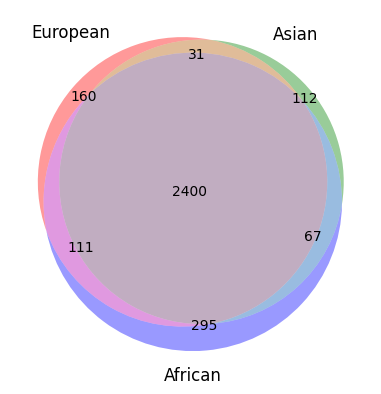

In [ ]:
def venn_diagram(a, b, c, labels=['European', 'Asian', 'African']):
  a = set(a)
  b = set(b)
  c = set(c)

  only_a = len(a - b - c)
  only_b = len(b - a - c)
  only_c = len(c - a - b)

  only_a_b = len(a & b - c)
  only_a_c = len(a & c - b)
  only_b_c = len(b & c - a)

  a_b_c = len(a & b & c)

  venn3(subsets=(only_a, only_b, only_a_b, only_c, only_a_c, only_b_c, a_b_c), set_labels=labels)
  return

venn_diagram(pruned_European_snps['SNP_id'].tolist(), pruned_Asian_snps['SNP_id'].tolist(), pruned_African_snps['SNP_id'].tolist())

In [ ]:
def get_effect_sizes(pruned_snps, trimmed_sumstats, trimmed_snp):
  """
  This takes the LD pruned SNP info and assigns the appropriate effect sizes to all SNPs
  """

  snp_ids = pruned_snps['SNP_id']
  # Get the indices of trimmed_CEU_snp corresponding to these SNP IDs
  matching_row_indices = [trimmed_snp.index.get_loc(snp_id) for snp_id in snp_ids if snp_id in trimmed_snp.index]

  matching_row_indices_set = set(matching_row_indices) #this should be faster
  #loop through indices/rows, if it matches up, append appropriate causal effect size

  effect_sizes = []
  for i, (index, row) in enumerate(trimmed_snp.iterrows()):
    if i in matching_row_indices_set:
      z_value = trimmed_sumstats.loc[trimmed_sumstats['SNP'] == index, 'Z'].values[0]
      effect_sizes.append(z_value)

    else:
      effect_sizes.append(0)

  effect_sizes = np.array(effect_sizes)
  return effect_sizes

In [ ]:
effect_sizes_European = get_effect_sizes(pruned_European_snps, trimmed_sumstats, trimmed_CEU_snp)
effect_sizes_Asian = get_effect_sizes(pruned_Asian_snps, trimmed_sumstats, trimmed_CEU_snp)
effect_sizes_African = get_effect_sizes(pruned_African_snps, trimmed_sumstats, trimmed_CEU_snp)

In [ ]:
def compute_pi(row):
    value = []
    for geno in row:
        if geno in [0,1,2]:
            value += [geno]
    pi = (sum(value)/len(value))/2
    return pi

def compute_norm(genotype_row):
    pi = compute_pi(genotype_row)
    return (2 * pi * (1 - pi)) ** (1/2), pi

def normalize_data(genotype):
    normalization_factors = []
    norm_genotype = []
    for i in range(len(genotype)):
        new_genotype_array = []
        normalize_factor, pi = compute_norm(genotype[i])
        normalization_factors += [(normalize_factor, pi)]
        for j in range(len(genotype[i])):
            if genotype[i][j] in [0,1,2]:
                new_genotype_array += [(genotype[i][j] - 2 * pi)/normalize_factor]
            else:
                new_genotype_array += [0]
        norm_genotype += [np.array(new_genotype_array)]
    return np.array(norm_genotype)

X_European = normalize_data(European_geno_data)
X_Asian = normalize_data(Asian_geno_data)
X_African = normalize_data(African_geno_data)

In [ ]:
heritability = .2 #WAS 0.2

beta_values_European = effect_sizes_European * np.sqrt((heritability / np.var(np.dot(X_European.T, effect_sizes_European))))
beta_values_Asian = effect_sizes_Asian * np.sqrt((heritability / np.var(np.dot(X_Asian.T, effect_sizes_Asian))))
beta_values_African = effect_sizes_African * np.sqrt((heritability / np.var(np.dot(X_African.T, effect_sizes_African))))

In [ ]:
print(np.var(np.dot(X_European.T, beta_values_European)))
print(np.var(np.dot(X_Asian.T, beta_values_Asian)))
print(np.var(np.dot(X_African.T, beta_values_African)))

0.20000000000000007
0.2000000000000001
0.20000000000000004


In [ ]:
np.random.seed(28)
Y_sim_European = np.dot(X_European.T, beta_values_European) + np.random.normal(0, np.sqrt(1 - heritability), X_European.shape[1])
Y_sim_Asian = np.dot(X_Asian.T, beta_values_Asian) + np.random.normal(0, np.sqrt(1 - heritability), X_Asian.shape[1])
Y_sim_African = np.dot(X_African.T, beta_values_African) + np.random.normal(0, np.sqrt(1 - heritability), X_African.shape[1])

In [ ]:
print(np.var(Y_sim_European))
print(np.var(Y_sim_Asian))
print(np.var(Y_sim_African))

1.0575327143441713
0.8318440547822489
1.013854653370597


In [ ]:
#Check if R^2 between BX and Y is heritability
def compute_r2(array1, array2):
    diff_array1 = array1 - np.mean(array1)
    diff_array2 = array2 - np.mean(array2)
    covariance = np.sum(diff_array1 * diff_array2)/(len(array1))
    variance_1 = np.sum(np.square(diff_array1))/(len(array1))
    variance_2 = np.sum(np.square(diff_array2))/(len(array2))
    if variance_1 != 0 and variance_2 != 0:
        return np.square(covariance)/(variance_1 * variance_2)
    return 0

print(compute_r2(Y_sim_European, np.dot(X_European.T, beta_values_European)))
print(compute_r2(Y_sim_Asian, np.dot(X_Asian.T, beta_values_Asian)))
print(compute_r2(Y_sim_African, np.dot(X_African.T, beta_values_African)))


0.18733025345233087
0.1713015843410702
0.23978170050243072


In [ ]:
with open('genotype.npy', 'wb') as f:
  np.save(f, X_European)
  np.save(f, X_Asian)
  np.save(f, X_African)
with open('phenotype.npy', 'wb') as f:
  np.save(f, Y_sim_European)
  np.save(f, Y_sim_Asian)
  np.save(f, Y_sim_African)

# Risk Prediction

In [5]:
with open('genotype.npy', 'rb') as f:
  X_European = np.load(f)
  X_Asian = np.load(f)
  X_African = np.load(f)
with open('phenotype.npy', 'rb') as f:
  Y_sim_European = np.load(f)
  Y_sim_Asian = np.load(f)
  Y_sim_African = np.load(f)

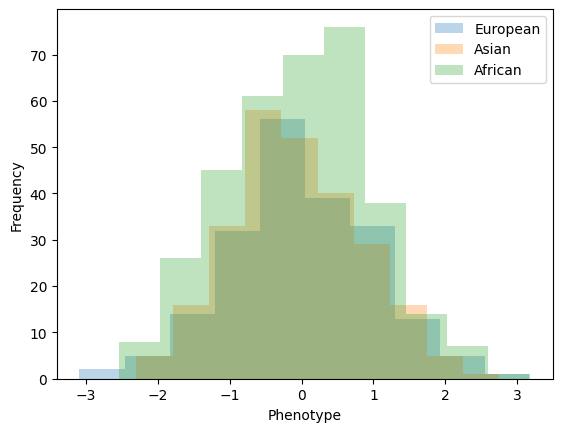

In [17]:
plt.hist(Y_sim_European, alpha = 0.3, label = "European")
plt.hist(Y_sim_Asian, alpha = 0.3, label = "Asian")
plt.hist(Y_sim_African, alpha = 0.3, label = "African")
plt.xlabel("Phenotype")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [10]:
print(np.max(Y_sim_European), np.min(Y_sim_European))
print(np.mean(Y_sim_European))
print(np.var(Y_sim_European))

3.186280616181884 -3.0939019461974286
-0.013582114728877848
1.0575327143441713


In [18]:
def compute_p_val(chisq_val):
    return scipy.stats.chi2.sf(chisq_val, 1)

def get_relevant_indices(att_effect_size, value):
    indices = []
    for i in range(len(att_effect_size)):
        if att_effect_size[i] >= value:
            indices += [i]
    return indices

def compute_correlation_and_armitage(genotypes, phenotypes):
  X_sum = np.sum(genotypes)
  Y_sum = np.sum(phenotypes)
  X_sq_sum = np.sum(np.square(genotypes))
  Y_sq_sum = np.sum(np.square(phenotypes))

  numerator = len(genotypes) * (np.matmul(genotypes, phenotypes)) - (X_sum * Y_sum)
  denominator = np.sqrt(len(genotypes) * X_sq_sum - np.square(X_sum)) * np.sqrt(len(genotypes) * Y_sq_sum - np.square(Y_sum))
  correlation = numerator / denominator

  att = len(genotypes) * np.square(correlation)
  return correlation, att

def compute_r2(array1, array2):
    diff_array1 = array1 - np.mean(array1)
    diff_array2 = array2 - np.mean(array2)
    covariance = np.sum(diff_array1 * diff_array2)/(len(array1))
    variance_1 = np.sum(np.square(diff_array1))/(len(array1))
    variance_2 = np.sum(np.square(diff_array2))/(len(array2))
    if variance_1 != 0 and variance_2 != 0:
        return np.square(covariance)/(variance_1 * variance_2)
    return 0

def split_data(X, Y, train_split):
  np.random.seed(28)
  random_indices = np.random.permutation(X.shape[1])
  train_indices = random_indices[:int(X.shape[1] * train_split)]
  test_indices = random_indices[int(X.shape[1] * train_split):]

  X_train = X[:, train_indices]
  Y_train = Y[train_indices]
  X_test = X[:, test_indices]
  Y_test = Y[test_indices]
  return X_train, Y_train, X_test, Y_test


In [23]:
def perform_risk_prediction(X_train, Y_train, X_test, Y_test, val_split, num_cv):
  att_effect_size = []
  for i in range(len(X_train)):
    att_effect_size += [compute_correlation_and_armitage(X_train[i], Y_train)[1]]

  best_r2_overall = 0
  best_B_model_overall = None
  best_att_value_overall = None
  best_indices_overall = None
  p_values_overall = []
  att_training_values = {}

  for att in [0.00, 0.455, 1.642, 2.706, 3.852, 5.412, 6.635]: #p-value thresholding [1.0, -> 0.01]
    SNP_indices = get_relevant_indices(att_effect_size, att)
    best_r2_for_threshold = 0
    best_B_model_for_threshold = None
    best_att_value_for_threshold = None
    best_indices_for_threshold = None

    training_values = []


    num_samples = X_train.shape[1]
    np.random.seed(28)
    indices = np.random.permutation(num_samples)
    fold_size = num_samples // num_cv
    for fold in range(num_cv): #Cross-Validation

      # OLD CODE CAN DELETE
      # #np.random.seed(28)
      # random_indices = np.random.permutation(X_train.shape[1])
      # train_indices = random_indices[:int(X_train.shape[1] * (1 - val_split))]
      # val_indices = random_indices[int(X_train.shape[1] * (1 - val_split)):]
      # X_train_train = X_train[:, train_indices]
      # Y_train_train = Y_train[train_indices]
      # X_val = X_train[:, val_indices]
      # Y_val = Y_train[val_indices]

      #Take every 20% of data to be validation for each fold
      #NOTE: NO LONGER USING val_split BC 5-FOLD CV IS .2 val_split really, can prob remove that param
      start_index = fold * fold_size
      end_index = start_index + fold_size
      val_indices = indices[start_index:end_index]
      train_indices = np.setdiff1d(indices, val_indices, assume_unique=True)

      X_train_train = X_train[:, train_indices]
      Y_train_train = Y_train[train_indices]
      X_val = X_train[:, val_indices]
      Y_val = Y_train[val_indices]

      X_train_train = X_train_train[SNP_indices]
      B_model = 1/len(X_train_train) * np.dot(Y_train_train, X_train_train.T)

      X_val = X_val[SNP_indices]
      Y_val_pred = np.dot(X_val.T, B_model)
      r2 = compute_r2(Y_val, Y_val_pred)
      #print(f"Our r2 is {r2}")


      # Plots Y true and Y pred
      # plt.figure(figsize=(8, 6))
      # plt.plot(Y_val, label='True Y', marker='o', linestyle='-', color='blue')
      # plt.plot(Y_val_pred, label='Pred Y', marker='s', linestyle='--', color='orange')

      # plt.title("Comparison of True and Pred", fontsize=14)
      # plt.xlabel("Samples", fontsize=12)
      # plt.ylabel("Values", fontsize=12)
      # plt.legend()
      # plt.grid(True)
      # plt.show()

      # numpy_r2 = np.square(np.corrcoef(Y_val, Y_val_pred)[0][1]) #Should be close to 0.1 or 0.2, but we see up to .9
      #print(f"numpy r2 is {numpy_r2}")

      training_values += [r2]

      if r2 > best_r2_for_threshold:
        best_r2_for_threshold = r2
        best_B_model_for_threshold = B_model
        best_att_value_for_threshold = att
        best_indices_for_threshold = SNP_indices


    att_training_values[att] = training_values

    if best_r2_for_threshold > best_r2_overall:
      best_r2_overall = best_r2_for_threshold
      best_B_model_overall = best_B_model_for_threshold
      best_att_value_overall = best_att_value_for_threshold
      best_indices_overall = best_indices_for_threshold

    p_values_overall += [(len(best_indices_for_threshold), compute_p_val(best_att_value_for_threshold), best_r2_for_threshold)]
  subset_X_test = X_test[best_indices_overall]
  Y_test_pred = np.matmul(subset_X_test.T, best_B_model_overall).T
  test_r2 = compute_r2(Y_test, Y_test_pred)
  return test_r2, len(best_indices_overall), p_values_overall, att_training_values

In [20]:
#Generate all Training and Testing Data
X_European_train, Y_sim_European_train, X_European_test, Y_sim_European_test = split_data(X_European, Y_sim_European, 0.6)
X_Asian_train, Y_sim_Asian_train, X_Asian_test, Y_sim_Asian_test = split_data(X_Asian, Y_sim_Asian, 0.6)
X_African_train, Y_sim_African_train, X_African_test, Y_sim_African_test = split_data(X_African, Y_sim_African, 0.6)

X_European_Asian_train = np.concatenate((X_European_train, X_Asian_train), axis=1)
Y_sim_European_Asian_train = np.concatenate((Y_sim_European_train, Y_sim_Asian_train), axis=0)
X_European_Asian_test = np.concatenate((X_European_test, X_Asian_test), axis=1)
Y_sim_European_Asian_test = np.concatenate((Y_sim_European_test, Y_sim_Asian_test), axis=0)

X_European_African_train = np.concatenate((X_European_train, X_African_train), axis=1)
Y_sim_European_African_train = np.concatenate((Y_sim_European_train, Y_sim_African_train), axis=0)
X_European_African_test = np.concatenate((X_European_test, X_African_test), axis=1)
Y_sim_European_African_test = np.concatenate((Y_sim_European_test, Y_sim_African_test), axis=0)

X_Asian_African_train = np.concatenate((X_Asian_train, X_African_train), axis=1)
Y_sim_Asian_African_train = np.concatenate((Y_sim_Asian_train, Y_sim_African_train), axis=0)
X_Asian_African_test = np.concatenate((X_Asian_test, X_African_test), axis=1)
Y_sim_Asian_African_test = np.concatenate((Y_sim_Asian_test, Y_sim_African_test), axis=0)

X_European_Asian_African_train = np.concatenate((X_European_train, X_Asian_train, X_African_train), axis=1)
Y_sim_European_Asian_African_train = np.concatenate((Y_sim_European_train, Y_sim_Asian_train, Y_sim_African_train), axis=0)
X_European_Asian_African_test = np.concatenate((X_European_test, X_Asian_test, X_African_test), axis=1)
Y_sim_European_Asian_African_test = np.concatenate((Y_sim_European_test, Y_sim_Asian_test, Y_sim_African_test), axis=0)

In [21]:
training_data = {"European": (X_European_train, Y_sim_European_train),
                 "Asian": (X_Asian_train, Y_sim_Asian_train),
                 "African": (X_African_train, Y_sim_African_train),
                 "European + Asian": (X_European_Asian_train, Y_sim_European_Asian_train),
                 "European + African": (X_European_African_train, Y_sim_European_African_train),
                 "Asian + African": (X_Asian_African_train, Y_sim_Asian_African_train),
                 "European + Asian + African": (X_European_Asian_African_train, Y_sim_European_Asian_African_train)}

testing_data = {"European": (X_European_test, Y_sim_European_test),
                 "Asian": (X_Asian_test, Y_sim_Asian_test),
                 "African": (X_African_test, Y_sim_African_test),
                 "European + Asian": (X_European_Asian_test, Y_sim_European_Asian_test),
                 "European + African": (X_European_African_test, Y_sim_European_African_test),
                 "Asian + African": (X_Asian_African_test, Y_sim_Asian_African_test),
                 "European + Asian + African": (X_European_Asian_African_test, Y_sim_European_Asian_African_test)}

In [24]:
num_cv = 5

training_results = {}
create_data_for_plotting = {}
for train_label in training_data:
  for test_label in testing_data:
    print(f"Training on {train_label} and testing on {test_label}")
    X_train, Y_train = training_data[train_label]
    X_test, Y_test = testing_data[test_label]
    r2_val, num_snps_for_test, p_values, training_vals = perform_risk_prediction(X_train, Y_train, X_test, Y_test, 0.25, num_cv)

    x_vals = [np.log10(i[0]) for i in p_values]
    y_vals = [i[1] for i in p_values] #p-values
    z_vals = [i[2] for i in p_values] #r^2 values
    create_data_for_plotting[f"({train_label})_({test_label})"] = [x_vals, y_vals, z_vals]
    training_results[f"({train_label})_({test_label})"] = training_vals
    print(f"r2_val on test data is {r2_val} which ran with {num_snps_for_test} SNPs \n")


Training on European and testing on European


LinAlgError: Last 2 dimensions of the array must be square

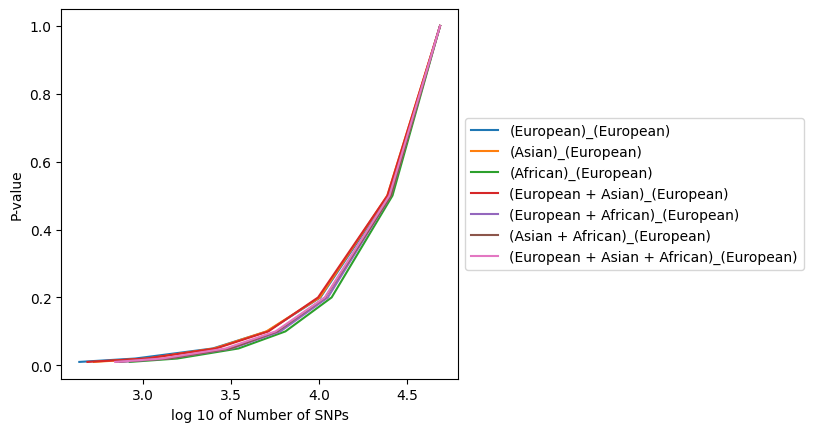

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)

for entry in create_data_for_plotting:
  if "(European)" == entry.split("_")[1]:
    x_vals = create_data_for_plotting[entry][0]
    y_vals = create_data_for_plotting[entry][1]
    ax.plot(x_vals, y_vals, label = entry)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('log 10 of Number of SNPs')
plt.ylabel('P-value')
plt.show()

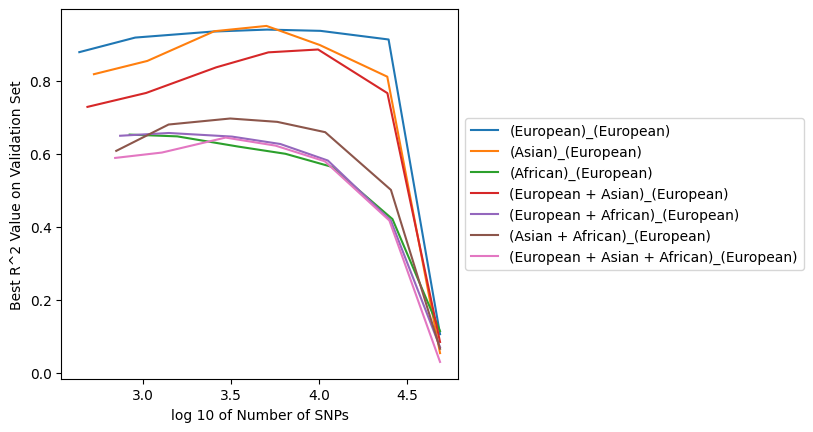

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)

for entry in create_data_for_plotting:
  if "(European)" == entry.split("_")[1]:
    x_vals = create_data_for_plotting[entry][0]
    y_vals = create_data_for_plotting[entry][2]
    ax.plot(x_vals, y_vals, label = entry)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('log 10 of Number of SNPs')
plt.ylabel('Best R^2 Value on Validation Set')
plt.show()

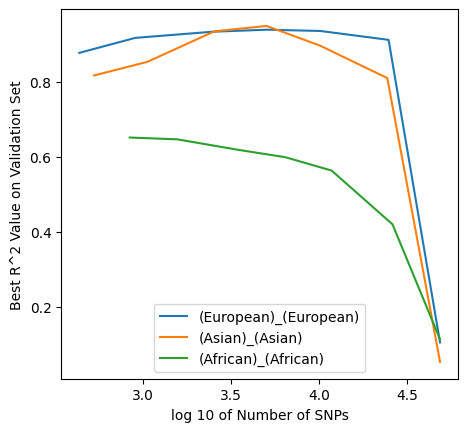

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)

values_to_include = ["(European)_(European)", "(Asian)_(Asian)", "(African)_(African)"]

for entry in create_data_for_plotting:
  if entry in values_to_include:
    x_vals = create_data_for_plotting[entry][0]
    y_vals = create_data_for_plotting[entry][2]
    ax.plot(x_vals, y_vals, label = entry)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='lower center')
plt.xlabel('log 10 of Number of SNPs')
plt.ylabel('Best R^2 Value on Validation Set')
plt.show()